# Removing Background Using a Neural Network

The training dataset for the Humpback Whale Identification on Kaggle has 25,361 images.  These images are of variable size, quality and background.  


## The Problem
Cropping this many images by hand is problematic, because it is incredibly time consuming.  For completness, I attempted to remove the background on one image using the free open source image editor Gimp.  This took approxamately 5 minutes.  So it can be estimated that if one was to crop the background out of the entire training dataset it would take 126,805 minutes or roughly 88 days provide you don't sleep, eat, or otherwise do anything but crop images.  

## Proposed Solution
Can a neural net be used to automate the work of cropping out the background on images of various size and quality?  The answer to the question is that it depends.  There are two ways to accomplish this task.

   * Train your model to recognize what is background and remove that.
   * Train your model to recognize what is a whale's tail and remove everything else.

In order to accomplish either of these tasks, the neural net needs to be able to identify what is background and what is an object.  Convolutional neural networks have been used to train object recognition models in the past.  These models can identify object types in images with many objects.  More importantly, these CNN's have been used to perform image manipulations such as drawing bounding boxes, creating a mask over the object, and labeling certain images with the object type. But these neural networks have been trained on datasets with 50,000+ images.  Which means that some number of people have gone through these large datasets and labeled these images.  Eventhough the Humpback Whale Identification dataset is only 25,000+ images, it is still too many 

So the revised question should be, can a much small number of training images be used to train a neural net model to remove the image background?  

## Software Used

The main Python modules needed for this are
   * OpenCV: A library for reading and manipulating images.
   * Numpy: For handling mulit-dimensional arrays that OpenCV will create and maniplulate.
   * Keras: A high level API for creating neural networks.
   * Tensorflow: A high level API used by Keras for creating neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from keras import backend as K
from scipy.misc import imresize
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import cv2
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline


Using TensorFlow backend.


## Creating a Smaller Training Set

Even with a small training dataset size of 349 images, this is still a time consumming process to try to remove the background by hand.  This is where software like OpenCV can help.

### Image Thresholding in OpenCV

With image thresholding, the user will transform the image based on a set of criteria that are specified to the threshold function.  As an example, take the original black and white image below.

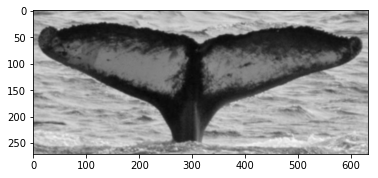

In [2]:
orig_dir = "/home/james/Kaggle/Whale/Data/train/1/"
img = cv2.imread(orig_dir + "/" + "8201ded69.jpg",0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye can easily tell where the tail is, and where the background is.  One could probably describe in detail what the background looks like, but that won't do a computer much good.  Even though the tail shows up in great detail.  The waves and surf also show up in great detail.  Which can make for a messy display.

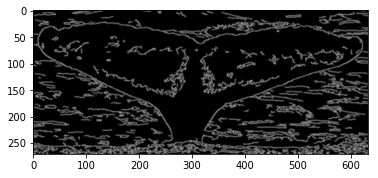

In [3]:
edges = cv2.Canny(img,100,200)
plt.imshow(edges, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye might be able to take a marker and draw the outline of the tail, but that description of what a tail and background, doesn't hold true anymore.  The main point in using the Canny function is to show that there are many more details in an image that may be imperceptible to the human eye, but are readily available to a computer when they are reading an image as an array of pixels. 

A technique that can be useful for sharpening lines is to run a filter over the image.  This can be done by using the filter2D function in OpenCV.  This will help later when we want to indentify the features of the tail.

In [4]:
# Sharpen Image
kernel = np.zeros( (9,9), np.float32)
kernel[4,4] = 2.0   #Identity, times two! 

#Create a box filter:
boxFilter = np.ones( (9,9), np.float32) / 81.0

#Subtract the two:
kernel = kernel - boxFilter

#Run the filter
sharpen = cv2.filter2D(img, -1, kernel)

Now a good way of cutting down unimportant features is to using a thresholding algormithm to reduce some of the background noise.  The threshold function in OpenCV will basicaly transform every pixel that meets the thresholding criteria, to a value which will be specied.  Therefore in the function call below, the threshold is set to 50, and the maximum value that will be used to replace the pixel if it falls below or above the threshold.  The last argument, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, is the type of threshold to use.  There are 6 different types of thresholding. I found that the adaptive threshold with a Gaussian window worked the best on large groups of images that vary in quality.  Therefore below, you can see what the threshold looks like

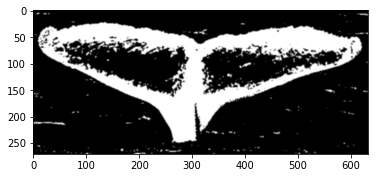

In [5]:
ret,thresh = cv2.threshold(sharpen,70,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic')
plt.show()

Now a computer should be able to outline the whale tail.  This can be done with OpenCV and it's findContours function.  This function will take the threshold value above and try to find the contours of the image.

In [6]:
_,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

So now we have a list of contours that the findContours function was able to find.  So now all that has to be done is to find the biggest contour.

In [7]:
contour_shape = {}
i = 0
for contour in contours:
    if contour.shape[0] > 500:
        contour_shape[contour.shape[0]] = i
    i += 1

contour_shape_keys = sorted(contour_shape)
try:
    c = contours[contour_shape[contour_shape_keys[-1]]]
except:
    print("Can't do:", file)

Then all that has to be done is to fill in this contour with black pixels and everything that is not a black pixel, convert them to white pixels.  This will yield the following mask.

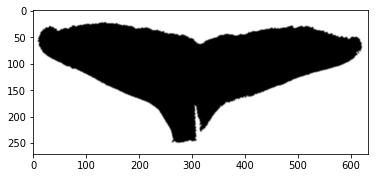

In [8]:
cv2.drawContours(img,[c],-1,(0,0,0),-1)
img[img != 0] = 255

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

This looks pretty great right?  So why don't we do this for all the images and just forget about the Neural Network in general?  This is because the thresholding algorithm can't take into account the overall brightness of the image.  It can't take into account when the tail is white already or black.  The next image illustrates this example.

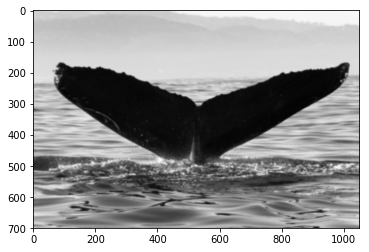

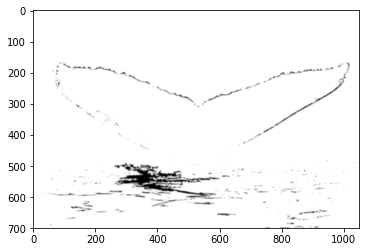

In [9]:
badimg = cv2.imread(orig_dir + "/" + "9119bb1a2.jpg",0)
plt.imshow(badimg, cmap = 'gray', interpolation = 'bicubic')
plt.show()

exampledir = "/home/james/Kaggle/Whale/Data/train/examples"
badmask = cv2.imread(exampledir + "/" + "9119bb1a2.jpg",0)
plt.imshow(badmask, cmap = 'gray', interpolation = 'bicubic')
plt.show()


So it can't get them all, but it can get quite a few.  You can use the above algorithm create masks for all 25000+ images and then flip through them manually and select the ones that worked properly.  This is not an exact science, but it is much better then using Gimp to do them by hand.

## Reading the Images into Memory

Place the masks into a directory, and the original images into another directory.  Then get the names of all the images into a list so they can be accessed when all of the images are looped over.

In [10]:
# set the necessary directories
data_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_real/"
mask_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_train/"

train_images = os.listdir(data_dir)

Neural network need a standardized input, and these images are of various sizes.  So a definition of a standard height and width will be needed so that the images can be resized.

In [11]:
height=256
width=256

When dealing with images, it is a good idea to create a function to read the data in.  in most machine learning functions you have features and labels.  In this example, the features are the pixels in images themselves and the label is the masks that were created above.  

In [12]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [13]:
def read_image(directory,image,dims):
    original_img = load_img(directory + image)
    resized_img = imresize(original_img, dims+[3])
    #Scale the image so that the model will converge faster
    array_img = img_to_array(resized_img)/255
    return array_img

In [14]:
def image_reader(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                array_img = read_image(data_dir,images[i],dims)
                imgs.append(array_img)
                
                # masks
                array_mask = read_image(mask_dir,images[i].split(".")[0] + '.jpg',dims)
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)

            labels = np.array(labels)
            
            # return both the images and the masks to the main program 
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

Now let's get started with making our actual network.

In [15]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [16]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [height, width, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

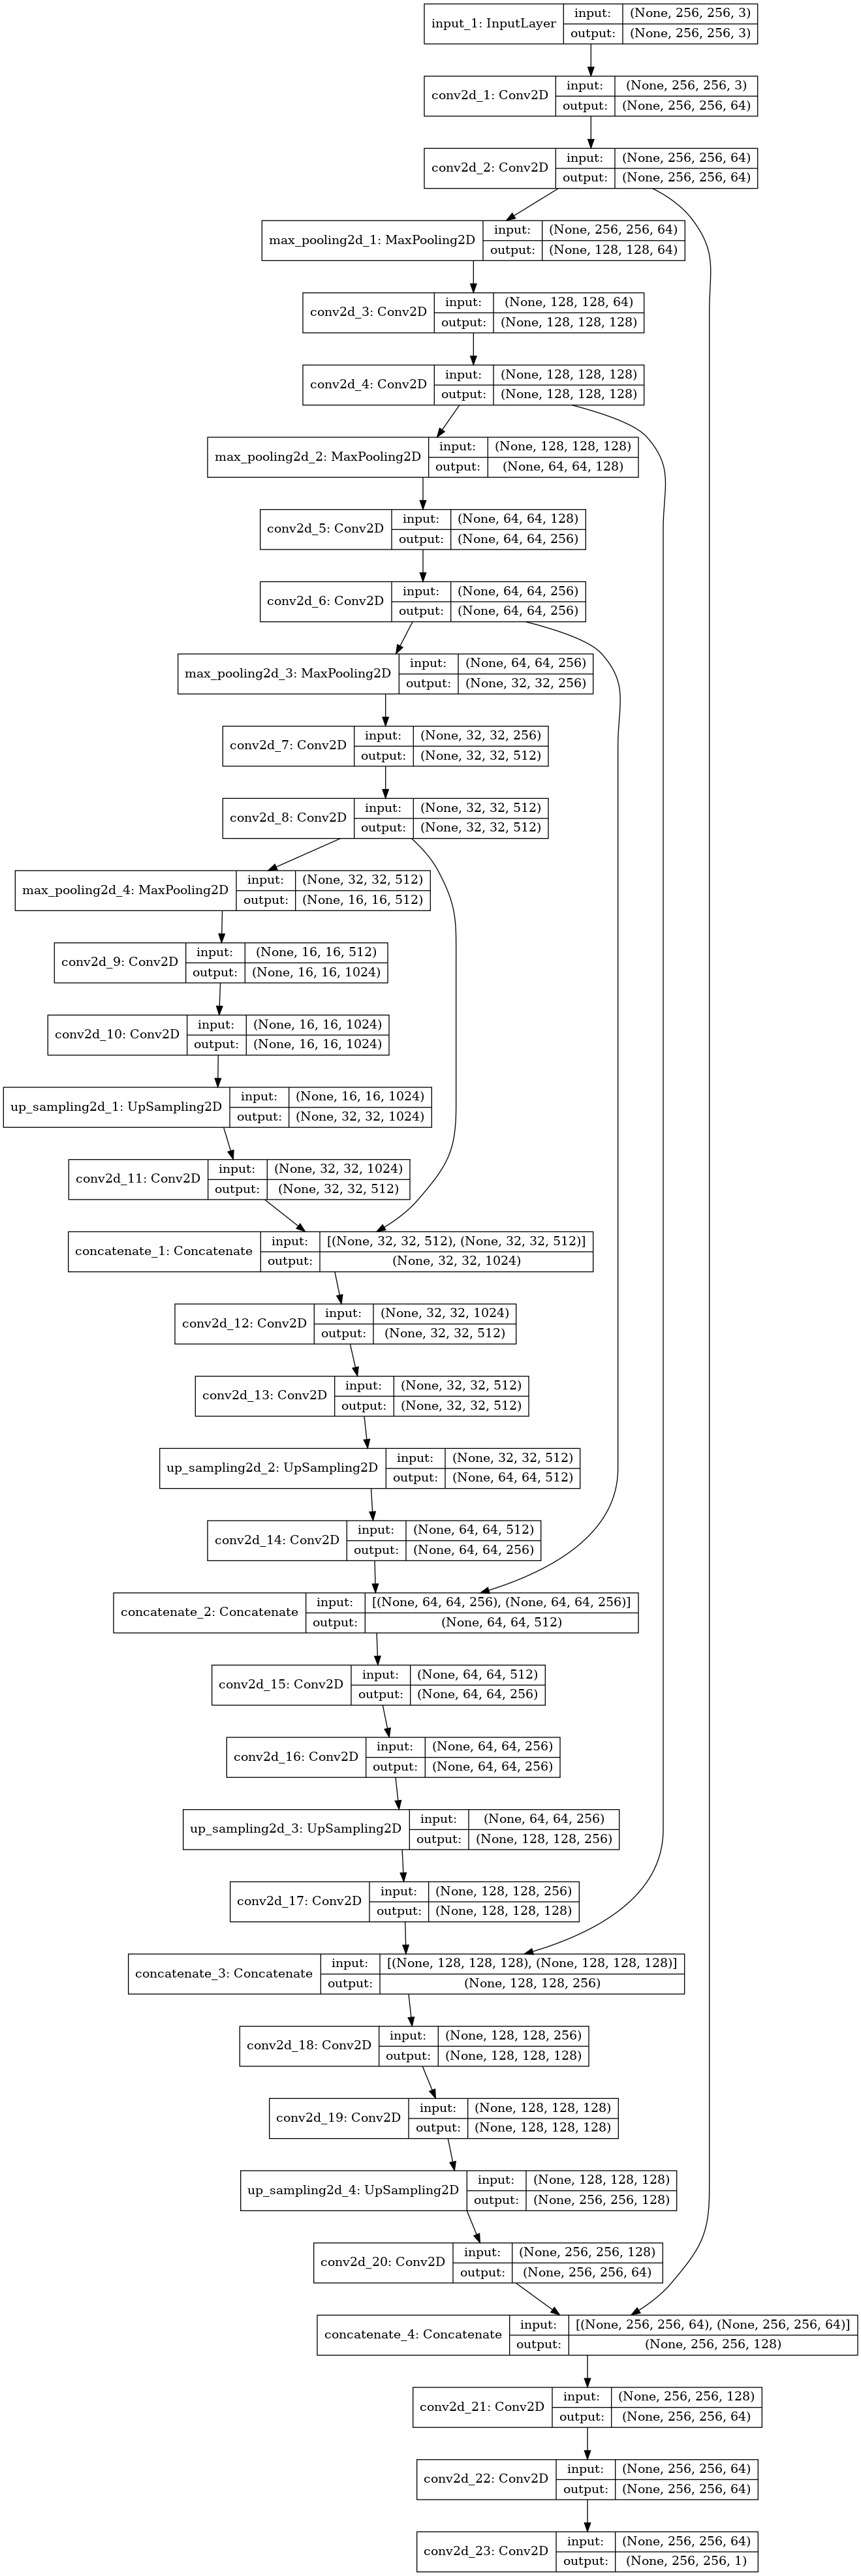

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [18]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = K.round(K.reshape(y_true, [-1]))
    y_pred = K.round(K.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

Now instantiate an instance of the image_reader function defined above.

In [19]:
train_gen = image_reader(data_dir, mask_dir, train_images, 5, [height, width])

It is best practice to use the Keras check pointing ability so that the best model can be saved to a file and loaded later on.  Also if the training gets interupted it can be restarted without loosing the already completed epochs.

In [20]:
filepath="/home/james/Kaggle/Whale/Data/train/whales-masks" + ".best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor="dice_coef",
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


callbacks_list = [checkpoint]

Now the model is compiled with binary_crossentropy and the custom metric dice_coef has been added.

In [21]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.fit_generator(train_gen, 
                    steps_per_epoch=100, 
                    epochs=20,
                    callbacks=callbacks_list
                   )

Epoch 1/20


/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


100/100 [==============================] - 80s 804ms/step - loss: 0.2784 - dice_coef: 0.8909

Epoch 00001: dice_coef improved from -inf to 0.89092, saving model to /home/james/Kaggle/Whale/Data/train/whales-masks.best.hdf5
Epoch 2/20
100/100 [==============================] - 59s 590ms/step - loss: 0.0914 - dice_coef: 0.9790

Epoch 00002: dice_coef improved from 0.89092 to 0.97898, saving model to /home/james/Kaggle/Whale/Data/train/whales-masks.best.hdf5
Epoch 3/20
100/100 [==============================] - 60s 595ms/step - loss: 0.0535 - dice_coef: 0.9865

Epoch 00003: dice_coef improved from 0.97898 to 0.98646, saving model to /home/james/Kaggle/Whale/Data/train/whales-masks.best.hdf5
Epoch 4/20
100/100 [==============================] - 59s 595ms/step - loss: 0.0413 - dice_coef: 0.9898

Epoch 00004: dice_coef improved from 0.98646 to 0.98978, saving model to /home/james/Kaggle/Whale/Data/train/whales-masks.best.hdf5
Epoch 5/20
100/100 [==============================] - 59s 594ms/st

## Remove the Background From All Images

Now that the the model has been trained.  It is time to run it on all 25,000+ images.  So like in the train images array, a test images array needs to be created.

In [22]:
origdir = "/home/james/Kaggle/Whale/Data/train/1/"
origmasksdir = "/home/james/Kaggle/Whale/Data/train/masks_all/"
origmaskimgdir = "/home/james/Kaggle/Whale/Data/train/masked_img/"
# Get all the image names into a list
test_images = os.listdir(origdir)
test_images.sort()

The image_reader function used above in the model.fit_generator can be used again to create an array of test images.

In [23]:
test_len = len(test_images)
# load best performing model
model.load_weights(filepath)

i=0
for filename in test_images:
    print(filename)
    image = read_image(origdir,filename,[height,width])
    
    image = image.reshape(-1, height, width, 3)
    prediction = model.predict(image)
    prediction = prediction.reshape(height,width, 1)
    prediction = grey2rgb(prediction)

    
    
    # Get the original image with now resizing
    orig_image = cv2.imread(origdir + filename,3)
    #plt.imshow(orig_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    orig_height = orig_image.shape[0]
    orig_width = orig_image.shape[1]
    # Convert the prediction mask to the same size as original image
    orig_mask = cv2.resize(prediction, (orig_width,orig_height))
    
    
    orig_mask[orig_mask > .5] = 255
    orig_mask[orig_mask < .5] = 0
    orig_mask = orig_mask.astype("uint8")
    
    #plt.imshow(orig_mask,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()

    background_image = cv2.subtract(orig_image,orig_mask)
    #plt.imshow(background_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    cv2.imwrite(origmasksdir + filename, orig_mask)
    cv2.imwrite(origmaskimgdir + filename, background_image)

    #if i == 100:
    #    break
    i+=1





0000e88ab.jpg


/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


0001f9222.jpg
00029d126.jpg
00050a15a.jpg
0005c1ef8.jpg
0006e997e.jpg
000a6daec.jpg
000f0f2bf.jpg
0016b897a.jpg
001c1ac5f.jpg
001cae55b.jpg
001d7450c.jpg
00200e115.jpg
00245a598.jpg
002b4615d.jpg
002f99f01.jpg
00355ff28.jpg
00357e37a.jpg
003795857.jpg
0041880bf.jpg
0043da555.jpg
00442c882.jpg
00464ff65.jpg
004775679.jpg
004ae9e26.jpg
004c0f43b.jpg
004e8ad5b.jpg
004f87702.jpg
0050ef29d.jpg
00514c876.jpg
0052ce2f5.jpg
00537ec91.jpg
00570db6b.jpg
005ce3100.jpg
00600ce17.jpg
006017ddf.jpg
0060f764a.jpg
006500b3d.jpg
006506edf.jpg
0067b3a20.jpg
006bdc6ff.jpg
00713060e.jpg
007218187.jpg
0073118da.jpg
007a7846f.jpg
007b62e05.jpg
007f3eb46.jpg
008124524.jpg
0084fe40b.jpg
0085064af.jpg
0085a6bd0.jpg
00869b59e.jpg
008bf89fc.jpg
008ebc50d.jpg
00910010d.jpg
00917baa4.jpg
0093454b6.jpg
009431af0.jpg
009589b45.jpg
0095fe89c.jpg
00961802f.jpg
009687166.jpg
0096c8ff3.jpg
009c45bc7.jpg
00a3dd76f.jpg
00a46c559.jpg
00a4de95e.jpg
00a70e649.jpg
00a9dc47d.jpg
00aae723d.jpg
00b7ffb8a.jpg
00b92e9bf.jpg
00bc4d

05d5db36c.jpg
05d6517f2.jpg
05d71e676.jpg
05d9cc57a.jpg
05da28fcb.jpg
05dae8342.jpg
05db04583.jpg
05dd0ee6b.jpg
05dfa3773.jpg
05e5e0e89.jpg
05e81e346.jpg
05ea19d75.jpg
05ea2c861.jpg
05ed57e10.jpg
05ee04d0c.jpg
05ee1fc22.jpg
05eeabf1b.jpg
05f2f037c.jpg
05f71b26a.jpg
05fc2e35d.jpg
060bacbc7.jpg
060ffd336.jpg
0610203d1.jpg
0611099f3.jpg
06119661c.jpg
0613a4aa9.jpg
0616cbd68.jpg
06171a8a9.jpg
06172ce2c.jpg
0617ca20a.jpg
0617cbeed.jpg
0618f6c38.jpg
061996245.jpg
061f833ab.jpg
06209926d.jpg
06245ed98.jpg
062699bef.jpg
06276874e.jpg
0628d4679.jpg
062d0bd7e.jpg
06306504e.jpg
06307bbf6.jpg
0631db372.jpg
06336bf78.jpg
0633e8c04.jpg
063759573.jpg
06389a1fc.jpg
0638c9ae1.jpg
063d5700d.jpg
063e89413.jpg
064bafe62.jpg
064dd41a3.jpg
064de9c50.jpg
06504fa5b.jpg
0654b3e5b.jpg
065b72556.jpg
065fbc00f.jpg
066074afc.jpg
066228078.jpg
066c039dc.jpg
0670b3636.jpg
0679f42ec.jpg
067cdde9d.jpg
067d80626.jpg
068062d67.jpg
0680aab46.jpg
06822966b.jpg
06848f3e1.jpg
0689a1032.jpg
068f9cdba.jpg
06907cb5c.jpg
06948b

0b92d79c0.jpg
0b961a0e2.jpg
0b9c56e0e.jpg
0b9e0d549.jpg
0ba05e099.jpg
0ba0e60f3.jpg
0ba1d8367.jpg
0ba2fe848.jpg
0ba3bb92d.jpg
0baa89964.jpg
0bb23359d.jpg
0bb469e7d.jpg
0bb5b9ae5.jpg
0bb67e44d.jpg
0bbf8f60a.jpg
0bc10f0f7.jpg
0bc2ff714.jpg
0bc4ab015.jpg
0bc500118.jpg
0bc8f5788.jpg
0bcb4b53a.jpg
0bcb9fc34.jpg
0bd1610f8.jpg
0bd64cea3.jpg
0bd65a44d.jpg
0bd7ff74f.jpg
0bda0c14f.jpg
0be63cacd.jpg
0be68a06b.jpg
0be897d0d.jpg
0bece9363.jpg
0bee24cfb.jpg
0bef01d4e.jpg
0bf303ed2.jpg
0bf8136cf.jpg
0bf9730f8.jpg
0bf980011.jpg
0c005aa88.jpg
0c037e179.jpg
0c057c0a6.jpg
0c076e252.jpg
0c08a4d6d.jpg
0c08f0cb6.jpg
0c0bf8fb8.jpg
0c0cea389.jpg
0c115fd9c.jpg
0c146080d.jpg
0c15936e3.jpg
0c166f137.jpg
0c18eda1c.jpg
0c1960aa4.jpg
0c19af6d4.jpg
0c1af7d67.jpg
0c2379d8a.jpg
0c25ed201.jpg
0c2653d9e.jpg
0c2adec98.jpg
0c30517d8.jpg
0c3197e04.jpg
0c341777d.jpg
0c36db7c9.jpg
0c3822f8c.jpg
0c39bd7ff.jpg
0c3afa7cd.jpg
0c3b7d753.jpg
0c401f637.jpg
0c44e92d7.jpg
0c45bf60f.jpg
0c4b0827e.jpg
0c4cf7f5d.jpg
0c508bef1.jpg
0c5147

11b442a49.jpg
11b51a782.jpg
11b619eca.jpg
11b9716d2.jpg
11c1054cf.jpg
11c3065f2.jpg
11c5985dd.jpg
11c839069.jpg
11c985217.jpg
11cd20bbc.jpg
11ceb760d.jpg
11d39fc43.jpg
11d57cd9c.jpg
11df60816.jpg
11e29e5e2.jpg
11e370e11.jpg
11e3ea5f6.jpg
11e7f96c5.jpg
11e907470.jpg
11edd672b.jpg
11f476f56.jpg
11f591047.jpg
11f59c2b3.jpg
11f98ade5.jpg
11fc1d26c.jpg
1202f27b4.jpg
12035e558.jpg
12037f781.jpg
1204c90d2.jpg
12093d2aa.jpg
120bbc906.jpg
120f5245d.jpg
12126d255.jpg
121819c9a.jpg
12184a9dc.jpg
121880d7f.jpg
121a7c56b.jpg
121db0677.jpg
121e3acc2.jpg
121e713b1.jpg
1222fa72b.jpg
1226da218.jpg
122d0e026.jpg
122f497db.jpg
122fbab73.jpg
1232d5324.jpg
1235eb22c.jpg
1236b667c.jpg
1239463f4.jpg
123b794ba.jpg
1242405d7.jpg
124254cb7.jpg
1244ce135.jpg
124913ed3.jpg
124a0e40a.jpg
124b1ef2d.jpg
12509a8e1.jpg
12518411d.jpg
1255a88bc.jpg
125869ae7.jpg
125b7d50d.jpg
125ba1407.jpg
125c6370c.jpg
126002936.jpg
1262321e3.jpg
1262dba60.jpg
12670516b.jpg
1268ef193.jpg
126e44013.jpg
126fc51b0.jpg
1270df73e.jpg
1272df

1802f4d47.jpg
180380bcc.jpg
18063def0.jpg
180a18d6e.jpg
180e98c54.jpg
181020979.jpg
181115c88.jpg
1812eeb95.jpg
181677b84.jpg
1818cfcbb.jpg
181ecc608.jpg
181fd95f4.jpg
182110c20.jpg
1822b7c68.jpg
18234111f.jpg
1825014de.jpg
18251a799.jpg
1829ac06d.jpg
182ac1bf2.jpg
182d5e290.jpg
18322eb9f.jpg
1837eedd8.jpg
183ae60da.jpg
18459a654.jpg
1845b343b.jpg
1847e87ee.jpg
184b85d7d.jpg
1850b6e39.jpg
18554c028.jpg
1855dac14.jpg
1860fb96e.jpg
1867e30c2.jpg
1868691a1.jpg
186dc4deb.jpg
1871a772e.jpg
1873d094a.jpg
18746ba21.jpg
1876ff23d.jpg
18780491e.jpg
187bb1839.jpg
1883237ff.jpg
188616175.jpg
1887a9835.jpg
188b04c45.jpg
188e5e66e.jpg
188f220f2.jpg
1891111cf.jpg
1892d17c2.jpg
1895c79c5.jpg
189a97d50.jpg
189b44a9d.jpg
189d5937b.jpg
189d85e90.jpg
18a26f162.jpg
18a278983.jpg
18a35d725.jpg
18a618c6b.jpg
18a6a8885.jpg
18a6dceea.jpg
18a73e2ee.jpg
18aae894c.jpg
18af303c2.jpg
18b2cfff5.jpg
18b36c8dc.jpg
18b39de07.jpg
18b7adcfa.jpg
18b9ebd3c.jpg
18bc422ca.jpg
18c3f55d6.jpg
18c7549fe.jpg
18c7f0c14.jpg
18ce3a

1e210d936.jpg
1e246b8da.jpg
1e29532df.jpg
1e2c317a7.jpg
1e2f9b457.jpg
1e305701a.jpg
1e38164a7.jpg
1e38ba8e7.jpg
1e38e1550.jpg
1e3f3af7f.jpg
1e44b642c.jpg
1e44fc47a.jpg
1e4617d24.jpg
1e49df4d4.jpg
1e4b4581c.jpg
1e4b60cdd.jpg
1e4b8c2cf.jpg
1e4dfe5d2.jpg
1e4e80b25.jpg
1e51290a9.jpg
1e5296b34.jpg
1e555128e.jpg
1e55ac126.jpg
1e58763df.jpg
1e592515e.jpg
1e5c68b0c.jpg
1e5e7b47a.jpg
1e603228d.jpg
1e6555ae4.jpg
1e65fef55.jpg
1e6952f12.jpg
1e69ad0e3.jpg
1e6a260b7.jpg
1e6a774fa.jpg
1e7271c12.jpg
1e73ca94a.jpg
1e73f3ede.jpg
1e762d038.jpg
1e78cdeb7.jpg
1e795c3d3.jpg
1e7a69eb8.jpg
1e7d9a510.jpg
1e85fdd1a.jpg
1e8b51160.jpg
1e8c1aa9f.jpg
1e8eec843.jpg
1e8f91b2c.jpg
1e9244dbe.jpg
1e97d5520.jpg
1e9aa4f1f.jpg
1e9ca6e57.jpg
1ea3df0b4.jpg
1ea4dca23.jpg
1ea766b42.jpg
1ea98999c.jpg
1ead12359.jpg
1eafa2bb4.jpg
1eb26eedd.jpg
1eb6554f3.jpg
1eb6ae4a6.jpg
1eb7a0671.jpg
1eb881661.jpg
1eb8b1f2d.jpg
1eb8eff24.jpg
1eb98f3be.jpg
1ebc69e97.jpg
1ec00b281.jpg
1ec04cc20.jpg
1ec0d128c.jpg
1ec170983.jpg
1ec863e20.jpg
1eccad

241c16bd3.jpg
241e38166.jpg
241fa79b9.jpg
242213b95.jpg
242238017.jpg
24225d859.jpg
2423c2da1.jpg
2423f48c1.jpg
24263e2e1.jpg
2426d1e5b.jpg
2427b1a3e.jpg
242a7f02b.jpg
242b46917.jpg
242f501ae.jpg
24310205b.jpg
243170b1b.jpg
2433348f1.jpg
243452737.jpg
2436e0e0f.jpg
243c9c87a.jpg
24402c6ac.jpg
2444c6ed3.jpg
244878f4f.jpg
245132f75.jpg
2453a6e65.jpg
2453c4631.jpg
2453dea33.jpg
24554c576.jpg
24579acdd.jpg
24587f7ed.jpg
245929082.jpg
245d27ea7.jpg
2463ec2a1.jpg
2464b5d43.jpg
24687d4e7.jpg
246a212f9.jpg
246a41d63.jpg
2470463d6.jpg
24712d686.jpg
247285a8d.jpg
24735fde4.jpg
2477ca3e8.jpg
247af9a7f.jpg
247e00dd7.jpg
24812755a.jpg
24813b7b9.jpg
24832c240.jpg
24885f014.jpg
248d3cd30.jpg
249045450.jpg
24921f77f.jpg
249481d7a.jpg
249583568.jpg
2496034e3.jpg
2496b8260.jpg
249f34fee.jpg
24a22415a.jpg
24a25d87b.jpg
24a29bb09.jpg
24a2d3fee.jpg
24a8edab4.jpg
24acea2d6.jpg
24af3682a.jpg
24b338103.jpg
24b409c38.jpg
24bd87f8d.jpg
24c1871b2.jpg
24c21121e.jpg
24c4dcc8b.jpg
24c68d5a3.jpg
24cb7c3e5.jpg
24cdd5

2a2cf502d.jpg
2a3023480.jpg
2a32b5011.jpg
2a339c434.jpg
2a340adf9.jpg
2a360f126.jpg
2a3613f4c.jpg
2a3df73dc.jpg
2a43a82c2.jpg
2a4510df9.jpg
2a4c8fcec.jpg
2a4e00ced.jpg
2a50449a9.jpg
2a54d72ea.jpg
2a594f207.jpg
2a5ac6133.jpg
2a5b2c31b.jpg
2a5f11848.jpg
2a61ed8cb.jpg
2a64fb056.jpg
2a653051a.jpg
2a65fac07.jpg
2a662973d.jpg
2a6782bb6.jpg
2a68af5ef.jpg
2a6b64f49.jpg
2a7172f00.jpg
2a720ecaa.jpg
2a744ee56.jpg
2a754e737.jpg
2a83780cb.jpg
2a8590b22.jpg
2a882f692.jpg
2a88d800a.jpg
2a8a16648.jpg
2a8f8289f.jpg
2a953477d.jpg
2a982b13b.jpg
2a9d5c279.jpg
2a9fce3d4.jpg
2a9fffbe6.jpg
2aa194f2f.jpg
2aa31dfa9.jpg
2aa548710.jpg
2aa6c7c04.jpg
2aab8d75c.jpg
2ab28a9b3.jpg
2ab3c0183.jpg
2ab410d32.jpg
2ab725d17.jpg
2ab8644ab.jpg
2aba33900.jpg
2aba65b94.jpg
2abfd1165.jpg
2ac19e867.jpg
2ac31f6fe.jpg
2ac3aff55.jpg
2ac595429.jpg
2aca22775.jpg
2acffdf4d.jpg
2ad0fd10f.jpg
2adadead5.jpg
2adbe5139.jpg
2add23160.jpg
2adf3e32e.jpg
2ae0a3a09.jpg
2ae1ca8e5.jpg
2ae2236ad.jpg
2ae368ab0.jpg
2ae61890a.jpg
2aea3c3da.jpg
2aeaff

2fea245f4.jpg
2fecc4c6d.jpg
2fedfe3ad.jpg
2fee6864f.jpg
2ff7687ea.jpg
2ff97413b.jpg
2ff988b9f.jpg
2ffa31138.jpg
2ffd3e80b.jpg
2ffd5ba97.jpg
30086e5a2.jpg
3008be490.jpg
300cf57a9.jpg
300eedf90.jpg
300f6e1cf.jpg
301653731.jpg
301b722fb.jpg
301be5b59.jpg
302108859.jpg
3022969e9.jpg
30271875f.jpg
302786c5d.jpg
302802011.jpg
302821f39.jpg
302a55053.jpg
30313cca2.jpg
3032488ef.jpg
303938df6.jpg
3039c91e5.jpg
303af19d7.jpg
303c19e56.jpg
303cbcbf6.jpg
303def2a3.jpg
303f7a4de.jpg
303fd8876.jpg
3040781e5.jpg
3041a3534.jpg
3042fbbfe.jpg
30452a68d.jpg
30471a388.jpg
305015649.jpg
3060de673.jpg
306198d1e.jpg
30624307c.jpg
30669294a.jpg
306733c15.jpg
306981bb3.jpg
306a035a1.jpg
306e29b2d.jpg
3071bc26f.jpg
3073d859e.jpg
307a82f97.jpg
308067dd3.jpg
30823c79e.jpg
3082ad4b1.jpg
30837e498.jpg
3084591fc.jpg
30847d905.jpg
3090d3069.jpg
30927d598.jpg
309b8afaa.jpg
309fa9c3a.jpg
30a64fe34.jpg
30a9973af.jpg
30aa68312.jpg
30ad0808d.jpg
30b462e55.jpg
30b5dc0b9.jpg
30bd700a3.jpg
30bed8ec9.jpg
30c1d5731.jpg
30c4c4

3606ea8b7.jpg
360715bdd.jpg
360a0d7d9.jpg
360a3a9d0.jpg
360bb6720.jpg
360c25b2b.jpg
360e1ce66.jpg
36129cf58.jpg
3612c5daf.jpg
3618fc309.jpg
361f2e9cb.jpg
3621d86a6.jpg
3623eae7a.jpg
3624091e0.jpg
3626c328e.jpg
362733513.jpg
362884102.jpg
362b56294.jpg
363110c4b.jpg
363169733.jpg
36337445a.jpg
3634d474b.jpg
3635aff02.jpg
363890e2f.jpg
363bad2ff.jpg
363ea3eca.jpg
3641717ad.jpg
364b4d9d5.jpg
364dd86d0.jpg
364f468af.jpg
364f75bf0.jpg
3653d500a.jpg
3657250e6.jpg
3659134a2.jpg
365f722dd.jpg
3662b6586.jpg
3667336e7.jpg
3669a356a.jpg
3669c86dd.jpg
366cfc070.jpg
367150343.jpg
3671adf0d.jpg
3673a0bc5.jpg
36770d9c3.jpg
367b8f052.jpg
367bb9fa7.jpg
367d2fe78.jpg
368365f40.jpg
368733de2.jpg
36875e12d.jpg
3689bbea9.jpg
368c1d011.jpg
368cfd705.jpg
368d1fcf7.jpg
36935beb9.jpg
3695b69d3.jpg
36972a2ed.jpg
36995599f.jpg
369bb52ed.jpg
369bbbcbf.jpg
369de80e0.jpg
369ed0645.jpg
36a055e3f.jpg
36a1e4e76.jpg
36a526aab.jpg
36a833f0a.jpg
36a84c071.jpg
36a93d72d.jpg
36aa1c73f.jpg
36af454c6.jpg
36b00587b.jpg
36b2d7

3c14f4eae.jpg
3c159d5d6.jpg
3c1ca5824.jpg
3c1f7fe58.jpg
3c216cb93.jpg
3c23285f9.jpg
3c257bca6.jpg
3c2c8b566.jpg
3c3393e26.jpg
3c34f0ebc.jpg
3c35ab685.jpg
3c3713488.jpg
3c38a0c7b.jpg
3c3ad9832.jpg
3c3d65b40.jpg
3c4235ad2.jpg
3c45fbb5b.jpg
3c46dc47c.jpg
3c48c62c2.jpg
3c553cff2.jpg
3c590a2d9.jpg
3c5ad708e.jpg
3c5bbc211.jpg
3c5d86b2a.jpg
3c731d8bd.jpg
3c7b51d15.jpg
3c81b70f4.jpg
3c8256238.jpg
3c8685029.jpg
3c87a722e.jpg
3c89b9105.jpg
3c8a8b718.jpg
3c8c1f7b3.jpg
3c8c68129.jpg
3c8e569cd.jpg
3c8e7258b.jpg
3c8f87463.jpg
3c90ae279.jpg
3c999ac78.jpg
3c99f9aef.jpg
3c9ccb9b5.jpg
3c9da89b6.jpg
3c9f6d426.jpg
3ca17bd73.jpg
3ca31ebd4.jpg
3ca357852.jpg
3cac77232.jpg
3cac7aed2.jpg
3cad1ad01.jpg
3cb040c0a.jpg
3cb24a6dd.jpg
3cb42d44b.jpg
3cb56f16e.jpg
3cb958ffd.jpg
3cba09780.jpg
3cbb9bb68.jpg
3cbc2e21a.jpg
3cbeb4d4a.jpg
3cbf65786.jpg
3cc647668.jpg
3cc71e9cc.jpg
3cc817781.jpg
3cc8cd1f2.jpg
3ccb3c187.jpg
3cce47a65.jpg
3ccfa4891.jpg
3cd0217f2.jpg
3cd47c00f.jpg
3cd5bc725.jpg
3cd6c9ac5.jpg
3cd828778.jpg
3cd924

41c978e42.jpg
41ca7dcb8.jpg
41cf6fd14.jpg
41d561a2d.jpg
41d801432.jpg
41de18c90.jpg
41de36d5e.jpg
41de42aa7.jpg
41df98a50.jpg
41e355f7c.jpg
41e398a98.jpg
41e73eb57.jpg
41ef21153.jpg
41f7d1047.jpg
41fb1eb8a.jpg
41fed9cca.jpg
42020c994.jpg
4206f5114.jpg
4209bf0d9.jpg
420ad8215.jpg
420cc3ace.jpg
420e0e2f2.jpg
4212a3e1f.jpg
421312968.jpg
4213288c7.jpg
4214483ad.jpg
42150d155.jpg
4217039a6.jpg
4218095f9.jpg
421a5c978.jpg
421a764b4.jpg
421e93330.jpg
4220d13cf.jpg
422102670.jpg
42227afa6.jpg
422992064.jpg
422b49d19.jpg
422cfcdb3.jpg
422e1b58c.jpg
422e2a81d.jpg
4236edec6.jpg
4237c8fbe.jpg
42394e8bc.jpg
423ffd2c9.jpg
424689c9d.jpg
4246ec2b7.jpg
424a1defe.jpg
425611ea4.jpg
42575e722.jpg
425ac1cad.jpg
425b445da.jpg
425d03aef.jpg
425e8dc0c.jpg
425f763ca.jpg
4266e8df0.jpg
42673cfac.jpg
4267f88ab.jpg
4268fd0b3.jpg
42699c49e.jpg
426a28a9a.jpg
426a79122.jpg
426bd892f.jpg
426e7691a.jpg
4271c3ecc.jpg
4273282ff.jpg
4275b9298.jpg
42808c2d7.jpg
4280b266c.jpg
428146202.jpg
42817f75a.jpg
428b43417.jpg
428bf5

474e7aec8.jpg
474f3876e.jpg
475500ed1.jpg
475831893.jpg
4759d4aea.jpg
475e6f089.jpg
4761786c2.jpg
4761f87f2.jpg
47678ad87.jpg
476a0bdc8.jpg
476bfc1ec.jpg
476c2eb33.jpg
476cfbf4d.jpg
4771764bb.jpg
477317dbe.jpg
477539719.jpg
477bcf0f1.jpg
477ec0f89.jpg
477ee1c68.jpg
477fbae2b.jpg
4780ad614.jpg
4780b9c6a.jpg
4780dabe8.jpg
47847493c.jpg
478549f50.jpg
4785d33ff.jpg
47877d568.jpg
478a6a14c.jpg
478d3d5f5.jpg
478de5b6e.jpg
479307df9.jpg
47a1e0a6e.jpg
47a7dc6a9.jpg
47a93852a.jpg
47aceec14.jpg
47af8181e.jpg
47b1dd8b5.jpg
47b82f263.jpg
47b93577b.jpg
47b9c75d8.jpg
47bd1d3bb.jpg
47c4329e5.jpg
47cc2fa0a.jpg
47cc7b788.jpg
47cfc0f01.jpg
47d1582fc.jpg
47d2741ad.jpg
47d45971a.jpg
47d503102.jpg
47d77f7c9.jpg
47d949260.jpg
47d99aed9.jpg
47d9ad983.jpg
47dd731bc.jpg
47e04b769.jpg
47e0583c6.jpg
47e17af86.jpg
47e35f740.jpg
47e3c24dd.jpg
47e71881d.jpg
47e8f9e96.jpg
47eb9f93d.jpg
47ec9f6dc.jpg
47ed8ff8c.jpg
47ef1eae1.jpg
47f3035d5.jpg
47f583530.jpg
47f63a55d.jpg
47f67d28c.jpg
47f88ae6c.jpg
47fb03609.jpg
47ff23

4d3141425.jpg
4d316e82e.jpg
4d33cec45.jpg
4d36abc45.jpg
4d378a0b2.jpg
4d478723a.jpg
4d4bf22c9.jpg
4d4cfd4a8.jpg
4d4d85fba.jpg
4d4f4ad11.jpg
4d503bc95.jpg
4d54fee74.jpg
4d5a2a26a.jpg
4d5d6461e.jpg
4d5e0a310.jpg
4d5e2d509.jpg
4d6002e1f.jpg
4d630f1ce.jpg
4d668f23b.jpg
4d6d63d92.jpg
4d7262a1e.jpg
4d7655942.jpg
4d7807a96.jpg
4d783a79c.jpg
4d784d3c0.jpg
4d7ad0c3a.jpg
4d7ae7ecc.jpg
4d7b41bb0.jpg
4d7bbc98b.jpg
4d8113e69.jpg
4d811f646.jpg
4d8214aaa.jpg
4d830aee3.jpg
4d83389ad.jpg
4d8da1776.jpg
4d92c21b7.jpg
4d93919c9.jpg
4d9488f38.jpg
4d97e54b7.jpg
4d99624f9.jpg
4d9c4a1a0.jpg
4d9e8172d.jpg
4d9fc178b.jpg
4da030702.jpg
4da3cf9ac.jpg
4da42e23a.jpg
4da6b3c6b.jpg
4da77a44d.jpg
4da84bff4.jpg
4dacd08ab.jpg
4db0c011a.jpg
4db20e526.jpg
4db51e355.jpg
4db8c61cd.jpg
4dbdd08b8.jpg
4dc2ef835.jpg
4dc36d838.jpg
4dc665d8f.jpg
4dc6796d4.jpg
4dc67d9b2.jpg
4dcf6412b.jpg
4dd08c554.jpg
4dd20c3b3.jpg
4dd4d6c7b.jpg
4dd7de9b0.jpg
4dd80d851.jpg
4dd81ac01.jpg
4dd9f1877.jpg
4dda2d639.jpg
4ddeeedf6.jpg
4de03f8ab.jpg
4de32a

532211939.jpg
532468dab.jpg
53293c1ea.jpg
532a3fe5f.jpg
532c79a37.jpg
532cbc031.jpg
533150966.jpg
5331dca6a.jpg
533329c32.jpg
533504534.jpg
5336ac99b.jpg
533871394.jpg
533f96782.jpg
534001e4c.jpg
534093323.jpg
534284730.jpg
5342e53d1.jpg
53476f77b.jpg
534ab659f.jpg
5353216d6.jpg
53540b6f2.jpg
5354272d6.jpg
53565e549.jpg
5357d3ab6.jpg
535a611be.jpg
535ed8a87.jpg
535f23a66.jpg
53613fa13.jpg
5361efb51.jpg
5363327d6.jpg
53669dd83.jpg
536905f44.jpg
536b3aeaa.jpg
5373691d4.jpg
5374d2558.jpg
537b6b9a8.jpg
5381c7ed3.jpg
5389be923.jpg
538eb9102.jpg
538f9f498.jpg
5390152f0.jpg
5391283ef.jpg
539272960.jpg
53950d512.jpg
53952ef60.jpg
53968ca4d.jpg
5396a7034.jpg
539c7cfcd.jpg
53a3ead5f.jpg
53ae827ab.jpg
53afe1a89.jpg
53b3c5ab9.jpg
53b845b3b.jpg
53bb428e9.jpg
53bb483de.jpg
53be367a4.jpg
53bef22bb.jpg
53c11c462.jpg
53c155eaa.jpg
53c38d05a.jpg
53c483ab5.jpg
53cb1c9b1.jpg
53d158a3b.jpg
53d217348.jpg
53d478023.jpg
53d82969e.jpg
53d84ff28.jpg
53d9c8700.jpg
53dbcaa94.jpg
53e1560fd.jpg
53e242bd9.jpg
53e84a

5963f163c.jpg
5966e9e70.jpg
5968f72be.jpg
596c89820.jpg
596ed9430.jpg
596f341e5.jpg
596fe9828.jpg
5970d9bbd.jpg
597122e6c.jpg
597e61c4b.jpg
597f2d162.jpg
5984c200c.jpg
5987b75dd.jpg
598efe3f2.jpg
598f1e614.jpg
59917a789.jpg
5992204a9.jpg
5993e9c5a.jpg
5997c5756.jpg
599941f8d.jpg
599c47954.jpg
599d99d80.jpg
599f3f2e3.jpg
59a149ef2.jpg
59a1a821c.jpg
59a1d21e3.jpg
59ab9ca5c.jpg
59ac1a67c.jpg
59acd323e.jpg
59b302402.jpg
59b4167ff.jpg
59b93962b.jpg
59b958888.jpg
59c282b8f.jpg
59c2c8e2a.jpg
59c361dc7.jpg
59c788f3e.jpg
59c88c3b8.jpg
59cb87622.jpg
59ced9f36.jpg
59d03644f.jpg
59d36b57e.jpg
59d39d538.jpg
59d3b62b9.jpg
59d7a9b49.jpg
59db3dea3.jpg
59dcbad4b.jpg
59e185d0c.jpg
59e375b85.jpg
59e87bd82.jpg
59ec87583.jpg
59f1dcb97.jpg
59f21e395.jpg
59f533487.jpg
59f5adc38.jpg
59fa2f74e.jpg
59fbee13c.jpg
59fca0fda.jpg
59fedaded.jpg
5a02bb81b.jpg
5a04494a6.jpg
5a0968b12.jpg
5a0c448f0.jpg
5a0c47114.jpg
5a0e09e88.jpg
5a0ed048f.jpg
5a1018b0c.jpg
5a10260eb.jpg
5a122bd98.jpg
5a17f640b.jpg
5a18b6471.jpg
5a1959

KeyboardInterrupt: 

In [ ]:
#Also do the test images

testdir="/home/james/Kaggle/Whale/Data/test/"
testorigdir = testdir + "1/"
origmasksdir = testdir + "masks_all/"
origmaskimgdir = testdir + "masked_img/"

# Get all the image names into a list
test_images = os.listdir(testorigdir)
test_images.sort()

model.load_weights(filepath)

i=0
for filename in test_images:
    print(filename)
    image = read_image(testorigdir,filename,[height,width])
    
    image = image.reshape(-1, height, width, 3)
    prediction = model.predict(image)
    prediction = prediction.reshape(height,width, 1)
    prediction = grey2rgb(prediction)

    
    
    # Get the original image with now resizing
    orig_image = cv2.imread(testorigdir + filename,3)
    #plt.imshow(orig_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    orig_height = orig_image.shape[0]
    orig_width = orig_image.shape[1]
    # Convert the prediction mask to the same size as original image
    orig_mask = cv2.resize(prediction, (orig_width,orig_height))
    
    
    orig_mask[orig_mask > .5] = 255
    orig_mask[orig_mask < .5] = 0
    orig_mask = orig_mask.astype("uint8")
    
    #plt.imshow(orig_mask,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()

    background_image = cv2.subtract(orig_image,orig_mask)
    #plt.imshow(background_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    cv2.imwrite(origmasksdir + filename, orig_mask)
    cv2.imwrite(origmaskimgdir + filename, background_image)

    #if i == 100:
    #    break
    i+=1





In [ ]:
#Reference: https://www.kaggle.com/ecobill/u-nets-with-keras